In [286]:
import numpy as np
import pandas as pd
    

In [287]:
number_of_trails = 1000
number_of_slot = 5


In [288]:
slot_machine_list=['slot_'+str(i) for i in range(1,number_of_slot+1)]
sucess_probability=[0.1, 0.4, 0.45, 0.6, 0.61]
for i in range(0,number_of_slot):
    print("The probablity of success for slot_{0}:{1:.2%}".format(
        i+1, sucess_probability[i]))


The probablity of success for slot_1:10.00%
The probablity of success for slot_2:40.00%
The probablity of success for slot_3:45.00%
The probablity of success for slot_4:60.00%
The probablity of success for slot_5:61.00%


In [289]:
enviroment=pd.DataFrame( columns = slot_machine_list)
for i in range(number_of_slot):
    enviroment['slot_'+str(i+1)]=np.random.binomial(1, sucess_probability[i], 1000)

In [309]:
slot_machine = {}
for number in range(1,number_of_slot+1):
    slot_machine[number] = pd.DataFrame( columns = ['Beta_dist','Sample', 'Rewards','Regret'],index=[i for i in range(number_of_trails)])
    dataset=slot_machine[number]
    for j in range(number_of_trails):
        dataset['Beta_dist'].loc[j]=np.array([1, 1])
for t in range(1,number_of_trails):
    sample_list=[]
    for number in range(1,number_of_slot+1):
        a=slot_machine[number]['Beta_dist'][t][0]
        b=slot_machine[number]['Beta_dist'][t][1]
        x=np.random.beta(a, b, size=None)
        slot_machine[number]['Sample'].iloc[t]=x
        sample_list.append(x)
        max_value = max(sample_list)
        max_index = sample_list.index(max_value)
    for number in range(1,number_of_slot+1):
        if number==max_index+1:
            if enviroment['slot_'+str(number)][t]==1:
                slot_machine[number]['Rewards'][t]=1
                slot_machine[number]['Beta_dist'][t]=slot_machine[number]['Beta_dist'][t-1]+np.array([1, 0])
            else:
                slot_machine[number]['Rewards'][t]=0
                slot_machine[number]['Beta_dist'][t]=slot_machine[number]['Beta_dist'][t-1]+np.array([0, 1])
        else:
            slot_machine[number]['Beta_dist'].iloc[t]=slot_machine[number]['Beta_dist'].iloc[t-1]
        mein_list=[max_value-item for item in sample_list]
        slot_machine[number]['Regret'][t]=max(mein_list)    
     


Calculating the result of each Bandit

In [291]:
df_rewards = {}
for i in range(1, number_of_slot + 1):
    df_rewards[i] = slot_machine[i][['Rewards']]
reward_sum = []
for i in range(1, number_of_slot + 1):
    reward_sum.append(df_rewards[i].sum(skipna=None).values[0])
reward_sum

[23.0, 80.0, 85.0, 125.0, 131.0]

Finding the index of the best Bandit

In [292]:
max_sum_index = np.argmax(reward_sum)
max_index=max_sum_index+1

The evolution of the posterior distributions of the estimated success probabilities over
the iterations of the Bandit.

In [293]:

def posterior(number):
    Beta_dist=slot_machine[number]['Beta_dist'].tolist()
    alpha=[item[0] for item in Beta_dist]
    beta=[item[1] for item in Beta_dist]
    return alpha, beta
    

In [294]:
import matplotlib.pyplot as plt
alpha={}
beta={}
for i in range(1,number_of_slot+1):
    alpha[i], beta[i]=posterior(i)
    


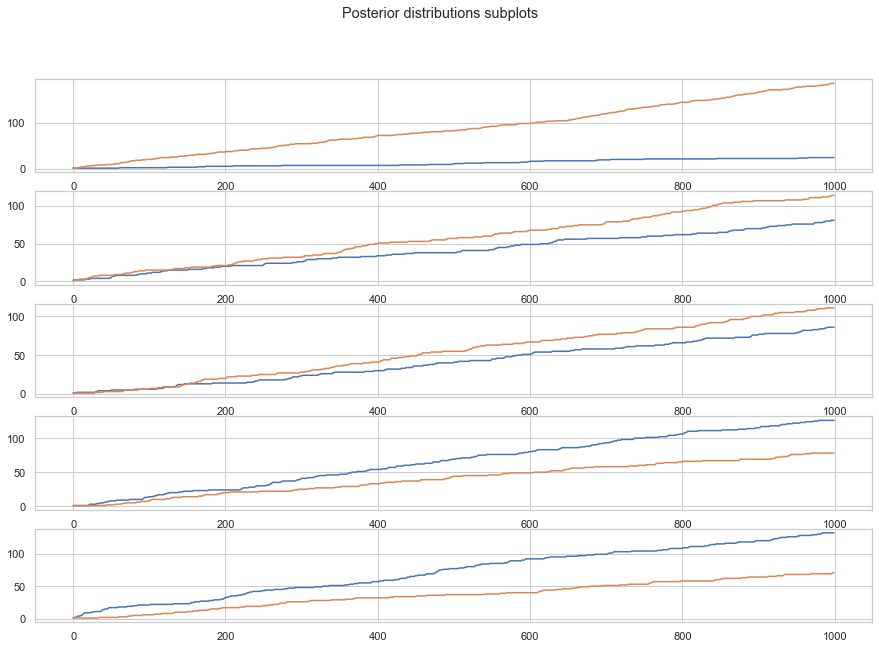

In [295]:
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(15, 10))
fig.suptitle('Posterior distributions subplots')
    
ax1.plot(range(len(Beta_dist)), alpha[1], label='alpha'+str(1))
ax1.plot(range(len(Beta_dist)), beta[1], label='beta'+str(1))
ax2.plot(range(len(Beta_dist)), alpha[2], label='alpha'+str(2))
ax2.plot(range(len(Beta_dist)), beta[2], label='beta'+str(2))
ax3.plot(range(len(Beta_dist)), alpha[3], label='alpha'+str(3))
ax3.plot(range(len(Beta_dist)), beta[3], label='beta'+str(3))
ax4.plot(range(len(Beta_dist)), alpha[4], label='alpha'+str(4))
ax4.plot(range(len(Beta_dist)), beta[4], label='beta'+str(4))
ax5.plot(range(len(Beta_dist)), alpha[5], label='alpha'+str(5))
ax5.plot(range(len(Beta_dist)), beta[5], label='beta'+str(5))




In [296]:
df_without=df_rewards[max_index].dropna().reset_index()[['Rewards']]
df_with=df_rewards[max_index][['Rewards']].replace(np.NaN,0)

The evolution of the Bandit’s best (point) estimate of the success probabilities over the entire iterations.

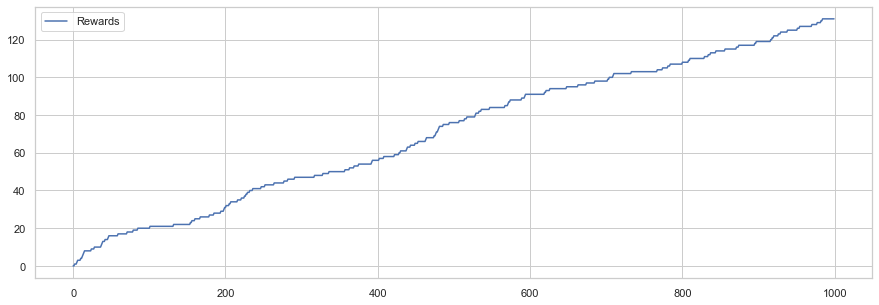

In [297]:

df_with.cumsum().plot(figsize=(15, 5))

The evolution of the Bandit’s best (point) estimate of the success probabilities over the iterations used for the best Bandit’s best.

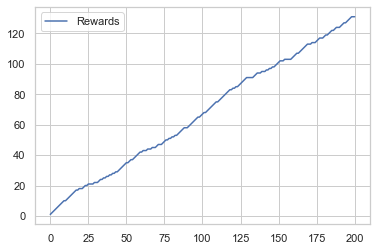

In [298]:
df_without.cumsum().plot()

Cumulative regret over time

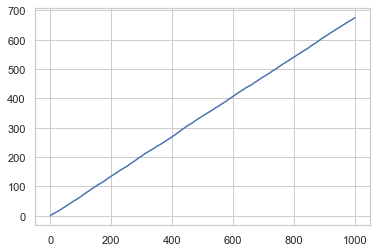

In [314]:
slot_machine[max_index]['Regret'].cumsum().plot()

How well does the algorithm discover the individual success probabilities?

The Thompson Sampling is a stochastic approach due to the sampling method. Based on the sampling of the posterior distribution of each arm, you allow the algorithm to balance exploration vs exploitation of the arms. In terms of how "well", you have to consider the stochastic nature of it, as well as other factors like time (10 rounds versus 1000 rounds).
Also with the cummulative regret, one can see the performance.


How does this relate to the probabilities themselves, and why?

we utilise the posterior probability distribution for sampling, and we update the posterior distribution using the observed reward information. For arms that are played fewer times, we get a wide uncertainty, and the sampling allows us to have a chance of picking them. By playing an arm more and more (increasing alpha or beta counts more), the Beta distribution becomes sharper and sharper, and it will eventually converge to the average value.